In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os as os
import tensorflow as ts
import tensorflow.keras as ks
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Read in Data


In [2]:
# read in data
df = pd.read_csv("./processed_data/pca_data.csv", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 477
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cinderella                 478 non-null    float64
 1   Number of Tournament Wins  478 non-null    float64
 2   3pt_0                      478 non-null    float64
 3   Free Throw-Rebound_0       478 non-null    float64
 4   Free Throw-Rebound_1       478 non-null    float64
 5   Free Throw-Rebound_2       478 non-null    float64
 6   Region_0                   478 non-null    float64
 7   PPG_0                      478 non-null    float64
 8   PPG_1                      478 non-null    float64
 9   Scoring Differential_0     478 non-null    float64
 10  Assist_0                   478 non-null    float64
 11  Schedule_0                 478 non-null    float64
 12  Win-Loss_0                 478 non-null    float64
dtypes: float64(13)
memory usage: 52.3 KB


## Create Model

### Neural Network

- Several fully-connected layers
    - Try 256, 128, 64, 32, 7/11
    
- In `.fit()`, 
    - use `sample_weights` parameter to weight certain outputs as worth more than others.
    - use `validation_split` to automatically set aside data for validation
    - use `shuffle` for shuffling samples when training
    
- Using Dropout layers with 0.05 and 0.1
    - 0.1 after layer 256
    - 0.05 after layer 128
    - 0.05 after layer 64
    
- Using `relu` activation function for all except last layer. Tested with `relu` and `relu6`.
- Using `softmax` activation fucntion on last layer to provide for probability distribution.

#### Output

##### Win-based

- 7 output nodes, predict number of wins (0-6)
    - Can look at problem as Classification
        - Use `y_dum` for predictions
        - Loss functions:
            - Categorical Cross Entropy: `categorical_crossentropy`
                - got around 99% accuracy at 300 epochs
            - KL Divergence: `kl_divergence`
                - got around 52% accuracy with `y` data at 300 epochs
                - got around 99% accuracy with `y_dum` data at 300 epochs
    - Can look at problem as Regression
        - Use `y` for predictions...maybe(?)
        - Loss functions:
            - Mean Squared Error: `mean_squared_error`
                - got around 25-30% accuracy with `y` at 300 epochs
                - got around 95% accuracy with `y_dum` data at 300 epochs
            - Sparse Categorical Cross Entropy: `sparse_categorical_crossentropy`
                - can only use `y` data
                - got around 99-100% accuracy at 300 epochs
            - Mean Absolute Error: `mean_absolute_error`
                - got around 66% accuracy with `y_dum` data at 300 epochs
                - got around 1% accuracy with `y` data at 300 epochs
- Must create function for evaluating how well the prediction worked for a given year
    - Evaluate score by selecting teams

##### Rank-based

- Find the optimal ranking of teams for each year
- 11 output nodes, predict which rank (0-10) the team should be placed in

#### Todo

- Use hyperparameterized, class-based optimization function, not just `adam` string.
- Try adding a layer of 512 nodes before layer of 256
- Use cross validation to ensure that the model is not overfitting
    - Train on pre-2021 data then use of 2021 to validate
- Use `sample_weights` hyperparameter to give more weight to higher win values
- Analyze output to see if model is under/overpredicting for misses
- Create datasets for what the optimal team selections are.
- Use early stopping if overfitting is an issue
- Somehow use scoring function as loss function
    - Could try using RL to select top 10 teams and figure out which top teams would be best


#### Misc Code

- Plot network with `ks.utils.plot_model(model, show_shapes=True)`
- Show summary with `model.summary()`

In [4]:
X = df.drop(columns=['Cinderella','Number of Tournament Wins'])
# y = df[['Cinderella','Number of Tournament Wins']]
y_dum = pd.get_dummies(df['Number of Tournament Wins'])
y = df['Number of Tournament Wins']

In [53]:
# Classification based

model_1 = ks.Sequential()

model_1.add(layers.Input(shape=X.shape[1], name='input'))

model_1.add(layers.Dense(256, activation='relu', kernel_regularizer = ks.regularizers.l2(.001)))

model_1.add(layers.Dropout(0.5))

model_1.add(layers.Dense(128, activation='relu', kernel_regularizer = ks.regularizers.l2(.001)))

model_1.add(layers.Dropout(0.5))

model_1.add(layers.Dense(64, activation='relu', kernel_regularizer = ks.regularizers.l2(.001)))

model_1.add(layers.Dropout(0.5))

model_1.add(layers.Dense(32, activation='relu', kernel_regularizer = ks.regularizers.l2(.001)))

model_1.add(layers.Dense(7, activation='softmax'))


In [54]:
model_1.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')
res = model_1.fit(X,y, epochs = 100, batch_size = 32, shuffle=True, validation_split=0.2)

Epoch 1/100
12/12 [==============================] - 1s 22ms/step - loss: 2.2562 - accuracy: 0.1963 - val_loss: 1.9664 - val_accuracy: 0.6458
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 1.9767 - accuracy: 0.4503 - val_loss: 1.6814 - val_accuracy: 0.6458
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 1.8249 - accuracy: 0.4817 - val_loss: 1.5784 - val_accuracy: 0.6458
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 1.6984 - accuracy: 0.5105 - val_loss: 1.5734 - val_accuracy: 0.6458
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 1.6411 - accuracy: 0.5026 - val_loss: 1.5461 - val_accuracy: 0.6458
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 1.6028 - accuracy: 0.5105 - val_loss: 1.5411 - val_accuracy: 0.6354
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 1.5675 - accuracy: 0.5262 - val_loss: 1.5949 - val_accuracy: 0.6458
Epoch 8/100


Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 1.1982 - accuracy: 0.5759 - val_loss: 2.2333 - val_accuracy: 0.5521
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 1.1459 - accuracy: 0.6073 - val_loss: 2.2563 - val_accuracy: 0.5833
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 1.1553 - accuracy: 0.6204 - val_loss: 2.2039 - val_accuracy: 0.5625
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 1.1071 - accuracy: 0.6230 - val_loss: 2.2300 - val_accuracy: 0.5521
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 1.1282 - accuracy: 0.6204 - val_loss: 2.3469 - val_accuracy: 0.5729
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 1.1072 - accuracy: 0.6230 - val_loss: 2.3914 - val_accuracy: 0.5417
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 1.1376 - accuracy: 0.6361 - val_loss: 2.4417 - val_accuracy: 0.5521
Epoch 

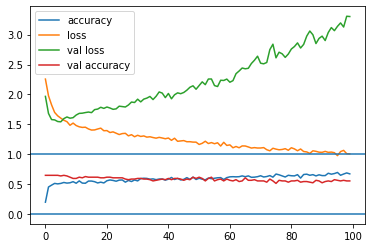

In [55]:
plt.plot(res.epoch, res.history['accuracy'], label='accuracy')
plt.plot(res.epoch, res.history['loss'], label='loss')
plt.plot(res.epoch, res.history['val_loss'], label='val loss')
plt.plot(res.epoch, res.history['val_accuracy'], label='val accuracy')
plt.axhline(y=0)
plt.axhline(y=1)
plt.legend()
plt.show()

## Validate Results

- Want to pick several Cinderella teams for bottom 4-6 predictions


## Save Model

- Save model to file along with relevant data